In [9]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

selected_etfs = ['IEMG', 'EEM', 'ARKK', 'ARKW', 'TLT', 'SPTL', 'SHY', 'VGSH','SOXX', 'ITA']


prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']

train_cutoff = pd.Timestamp("2020-01-01")

prices = prices.dropna()
all_pairs = [('IEMG', 'EEM'), ('ARKK', 'ARKW'), ('TLT', 'SPTL'), ('SHY', 'VGSH'),('SOXX', 'ITA')]

prices.info()


C:\Users\anair26\AppData\Local\Temp\ipykernel_18332\4194294657.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARKK    2515 non-null   float64
 1   ARKW    2515 non-null   float64
 2   EEM     2515 non-null   float64
 3   IEMG    2515 non-null   float64
 4   ITA     2515 non-null   float64
 5   SHY     2515 non-null   float64
 6   SOXX    2515 non-null   float64
 7   SPTL    2515 non-null   float64
 8   TLT     2515 non-null   float64
 9   VGSH    2515 non-null   float64
dtypes: float64(10)
memory usage: 216.1 KB


In [10]:
def generate_labels(z, upper=1.5, lower=-1.5):
    return np.where(z > upper, -1,    # SHORT spread
           np.where(z < lower, 1,     # LONG spread
           0))                        # No trade



In [11]:
import pandas as pd
import statsmodels.api as sm

# Assumes `prices` is your DataFrame of adjusted-close prices,
# and `all_pairs` is a list of tuples: [(etf1, etf2), …]

lookback = 30
spread_records = []

for etf_a, etf_b in all_pairs:
    # Align prices and drop any NaNs for the pair
    pair_prices = pd.concat([prices[etf_a], prices[etf_b]], axis=1).dropna()
    a = pair_prices[etf_a]
    b = pair_prices[etf_b]

    # 1) Estimate hedge ratio via OLS
    model = sm.OLS(a, sm.add_constant(b)).fit()
    hedge_ratio = model.params[etf_b]

    # 2) Compute spread and rolling statistics
    spread = a - hedge_ratio * b
    rolling_mean = spread.rolling(window=lookback).mean()
    rolling_std = spread.rolling(window=lookback).std()
    z_score = (spread - rolling_mean) / rolling_std
    rolling_volatility = z_score.rolling(window=lookback).std()

    # 3) Build DataFrame for this pair
    df_pair = pd.DataFrame({
        'Date': spread.index,
        'pair': f"{etf_a}-{etf_b}",
        'spread': spread,
        'rolling_mean': rolling_mean,
        'rolling_std': rolling_std,
        'z_score': z_score,
        'rolling_volatility': rolling_volatility
    })

    spread_records.append(df_pair)

# Combine all pairs into a single long-form DataFrame
spread_long = pd.concat(spread_records, ignore_index=True)

# label feature
spread_long['label'] = generate_labels(spread_long['z_score'])

# 4) Add lagged features for z_score and spread
spread_long['z_score_lag1'] = spread_long.groupby('pair')['z_score'].shift(1)
spread_long['spread_lag1'] = spread_long.groupby('pair')['spread'].shift(1)

spread_long['z_score_lag2'] = spread_long.groupby('pair')['z_score'].shift(2)
spread_long['spread_lag2'] = spread_long.groupby('pair')['spread'].shift(2)

spread_long['z_score_lag3'] = spread_long.groupby('pair')['z_score'].shift(3)
spread_long['spread_lag3'] = spread_long.groupby('pair')['spread'].shift(3)


# 5) Final cleanup
spread_long.dropna(inplace=True)
spread_long.sort_values(['pair', 'Date'], inplace=True)
spread_long.reset_index(drop=True, inplace=True)

# `spread_long` now contains columns:
# ['Date', 'pair', 'spread', 'rolling_mean', 'rolling_std',
#  'z_score', 'rolling_volatility', 'z_score_lag1', 'spread_lag1']


spread_long.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12285 entries, 0 to 12284
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                12285 non-null  datetime64[ns]
 1   pair                12285 non-null  object        
 2   spread              12285 non-null  float64       
 3   rolling_mean        12285 non-null  float64       
 4   rolling_std         12285 non-null  float64       
 5   z_score             12285 non-null  float64       
 6   rolling_volatility  12285 non-null  float64       
 7   label               12285 non-null  int64         
 8   z_score_lag1        12285 non-null  float64       
 9   spread_lag1         12285 non-null  float64       
 10  z_score_lag2        12285 non-null  float64       
 11  spread_lag2         12285 non-null  float64       
 12  z_score_lag3        12285 non-null  float64       
 13  spread_lag3         12285 non-null  float64   

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 


le_pairs = LabelEncoder()
spread_long['pair_encoded'] = le_pairs.fit_transform(spread_long['pair'])

print(spread_long['pair_encoded'])


0        0
1        0
2        0
3        0
4        0
        ..
12280    4
12281    4
12282    4
12283    4
12284    4
Name: pair_encoded, Length: 12285, dtype: int64


In [13]:
features = ['z_score_lag1', 'rolling_mean', 'z_score', 'z_score_lag3','z_score_lag2']
target = 'label'


train_spread_long = spread_long[spread_long['Date'] < train_cutoff]
test_spread_long = spread_long[spread_long['Date'] >= train_cutoff]

print(train_spread_long['Date'])


label_map = {-1: 0, 0: 1, 1: 2}

train_x = train_spread_long[features]
train_y = train_spread_long[target].map(label_map)

test_x = test_spread_long[features]
test_y = test_spread_long['label'].map(label_map)



0       2015-03-27
1       2015-03-30
2       2015-03-31
3       2015-04-01
4       2015-04-02
           ...    
11023   2019-12-24
11024   2019-12-26
11025   2019-12-27
11026   2019-12-30
11027   2019-12-31
Name: Date, Length: 6000, dtype: datetime64[ns]


In [14]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

model = xgb.XGBClassifier(
    objective='multi:softprob',  # For multi-class (long, short, neutral)
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False
)

param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [3, 5, 7],
    'learning_rate':   [0.01, 0.1, 0.2],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',    # or your custom backtest metric
    cv=3,                  # e.g. 3-fold CV (use TimeSeriesSplit for time series)
    verbose=1,
    n_jobs=-1
)

grid.fit(train_x, train_y)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred = best_model.predict(train_x)

inv_map = {v:k for k,v in label_map.items()}
y_pred_original = pd.Series(y_pred).map(inv_map)

from sklearn.metrics import classification_report

y_pred = best_model.predict(train_x)
print(classification_report(train_y, y_pred))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best CV score: 0.9980000000000001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       1.00      1.00      1.00      4559
           2       1.00      1.00      1.00       807

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



c:\Users\anair26\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:28:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


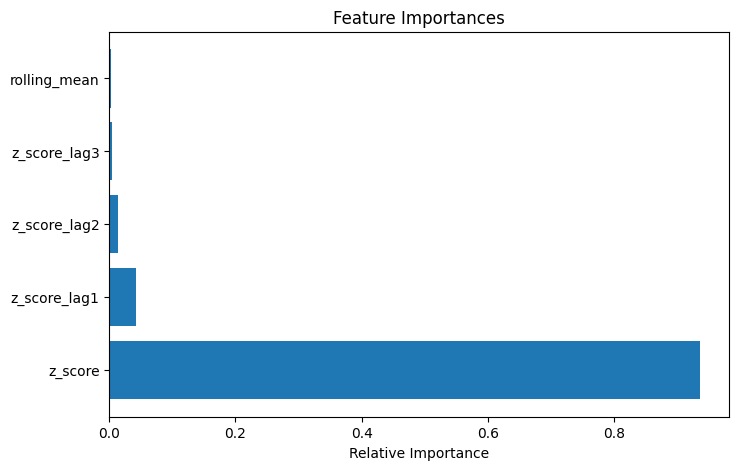

[0.00331803 0.0042898  0.01363205 0.04236114 0.936399  ]


In [15]:
def feature_importance(Model,feature_df):

    fi = Model.feature_importances_
    feat_names = feature_df.columns

    # Create a sorted bar chart
    indices = np.argsort(fi)[::-1]
    plt.figure(figsize=(8,5))
    plt.barh(feat_names[indices], fi[indices])
    plt.title("Feature Importances")
    plt.xlabel("Relative Importance")
    plt.show()

    print(np.sort(fi))

feature_importance(best_model,train_x)

In [ ]:
# TEST DATA

# 100 dollars to every pair
# Use probaility for each of the outcomes 1. long short 2. short long 3. hold - and probability thresholds to figure out when to follow through
# If we choose to long or short anything, hold that position for a specific portion of time 
# that amount we allocate will be based on the probability that we see -  (( Should we change allocation throughout the hold window? )) 

# Show individual returns, metrics, sharpe ratio - then joint 

# 1. Completed - test_x, test_y, and spread dataframe have the same rows - get rid of merge confusion

# 2 Completed - Short, hold, and long column in proba df - index and columns edited

proba_df = pd.DataFrame(best_model.predict_proba(test_x))

inv_map = {v: k for k, v in label_map.items()}
proba_df = proba_df.rename(columns=inv_map)
proba_df.columns = [f"prob_{col}" for col in proba_df.columns]
proba_df.index = test_x.index

proba_df.to_csv('yoo.csv')

# 3 

print(proba_df.head(100))

# Parameters defined
threshold_long = 0.5   # probability threshold to go long
threshold_short = 0.5  # probability threshold to go short
hold_period = 5        # holding window in days
initial_capital = 100  # capital per pair

proba_df['signal_raw'] = 0 # column initialize
proba_df.loc[proba_df['prob_1'] >= threshold_long, 'signal_raw'] = 1
proba_df.loc[proba_df['prob_-1'] >= threshold_short, 'signal_raw'] = -1

proba_df['signal_raw'].value_counts()

print(proba_df[['prob_-1','prob_0','prob_1','signal_raw']].head())




       prob_-1    prob_0    prob_1
0     0.228709  0.271052  0.500239
1     0.219695  0.254962  0.525343
2     0.220745  0.239437  0.539819
3     0.221360  0.235197  0.543443
4     0.243469  0.426620  0.329911
...        ...       ...       ...
6280  0.235006  0.498077  0.266917
6281  0.235139  0.488872  0.275990
6282  0.227187  0.539380  0.233434
6283  0.227788  0.529914  0.242298
6284  0.231129  0.336795  0.432076

[6285 rows x 3 columns]
       prob_-1    prob_0    prob_1
1200  0.228709  0.271052  0.500239
1201  0.219695  0.254962  0.525343
1202  0.220745  0.239437  0.539819
1203  0.221360  0.235197  0.543443
1204  0.243469  0.426620  0.329911
...        ...       ...       ...
1295  0.232020  0.538448  0.229532
1296  0.230007  0.542271  0.227722
1297  0.234429  0.539894  0.225677
1298  0.450264  0.319299  0.230438
1299  0.487164  0.286262  0.226574

[100 rows x 3 columns]
       prob_-1    prob_0    prob_1  signal_raw
1200  0.228709  0.271052  0.500239           1
1201  0.219695  0

In [ ]:
# # testing section: probability-based signals and simulation

# # 1. Predict probabilities on the test set
# proba = best_model.predict_proba(test_x)
# proba_df = pd.DataFrame(proba, index=test_x.index, columns=best_model.classes_)
# # Map encoded classes back to original labels and prefix
# inv_map = {v: k for k, v in label_map.items()}
# proba_df = proba_df.rename(columns=inv_map)
# proba_df.columns = [f"prob_{col}" for col in proba_df.columns]

# # 2. Flatten and merge on original index levels
# # Extract original index level names (e.g., ['Date', 'pair'])
# idx_names = test_spread_long.index.names
# # Reset index on spread DataFrame to turn levels into columns
# spread_df = test_spread_long.reset_index()
# # Ensure proba_df uses the same index names, then reset
# proba_df.index.names = idx_names
# proba_flat = proba_df.reset_index()
# # Merge on the index level columns
# df = spread_df.merge(proba_flat, on=idx_names, how='left')

# # 3. Strategy parameters
# threshold_long = 0.6   # probability threshold to go long
# threshold_short = 0.6  # probability threshold to go short
# hold_period = 5        # holding window in days
# initial_capital = 100  # capital per pair

# # 4. Generate signals
# import numpy as np

# def decide_signal(row):
#     # fallback to 0 if probability cols missing
#     p_long = row.get('prob_1', 0)
#     p_short = row.get('prob_-1', 0)
#     if p_long >= threshold_long:
#         return 1
#     elif p_short >= threshold_short:
#         return -1
#     else:
#         return 0

# # Raw signal and holding logic
# df['signal_raw'] = df.apply(decide_signal, axis=1)
# df['signal'] = (
#     df.groupby(idx_names[1])['signal_raw']
#       .apply(lambda x: x.replace(0, np.nan).ffill(limit=hold_period))
#       .fillna(0)
# )

# # 5. Compute returns & position sizing
# df['spread_ret'] = df.groupby(idx_names[1])['spread'].pct_change().shift(-1)
# df['strategy_ret'] = df['signal'] * df['spread_ret']
# # Dynamic position size based on max probability
# prob_cols = [c for c in df.columns if c.startswith('prob_')]
# df['position_size'] = (
#     df['signal_raw'].abs()
#     * df[prob_cols].max(axis=1)
#     * initial_capital
# )

# # 6. Performance metrics per pair
# def compute_metrics(group):
#     rets = group['strategy_ret'].dropna()
#     sharpe = (rets.mean() / rets.std()) * np.sqrt(252) if len(rets) > 1 else np.nan
#     cum_ret = (1 + rets).prod() - 1
#     return pd.Series({'sharpe': sharpe, 'cumulative_return': cum_ret})

# pair_metrics = df.groupby(idx_names[1]).apply(compute_metrics)
# print(pair_metrics)

# # 7. Aggregate portfolio performance
# daily_ret = df.groupby(idx_names[0])['strategy_ret'].mean()
# equity = (1 + daily_ret).cumprod() * initial_capital
# agg_sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if len(daily_ret) > 1 else np.nan
# agg_cum_return = equity.iloc[-1] / initial_capital - 1
# print(f"Aggregate Sharpe Ratio: {agg_sharpe:.2f}")
# print(f"Aggregate Cumulative Return: {agg_cum_return:.2%}")

# # 8. Optional: plot equity curve
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(equity.index, equity.values)
# plt.title('Equity Curve')
# plt.xlabel(idx_names[0])
# plt.ylabel('Portfolio Value')
# plt.show()
